# Assignment 8: Data Aggregation and Group Operations

## Overview
This assignment covers data aggregation and group operations using healthcare/insurance EHR data. You'll analyze patient encounters (insurance claims), healthcare providers, and medical facilities across different regions. The data includes provider statistics, facility information, and encounter charges with insurance coverage details.

## Setup

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
os.makedirs('output', exist_ok=True)

## Question 1: Basic GroupBy Operations

### Part 1.1: Load and Explore Data

**TODO: Load and merge the datasets**

In [42]:
# Load the three CSV files into dataframes
provider_df = pd.read_csv('data/provider_data.csv')
facility_df = pd.read_csv('data/facility_data.csv')
encounter_df = pd.read_csv('data/encounter_data.csv')

# Print the shapes of each dataframe
print("Provider data shape:", provider_df.shape)
print("Facility data shape:", facility_df.shape)
print("Encounter data shape:", encounter_df.shape)

# Merge the dataframes for analysis
# Drop duplicate region column, same between encounter and facility
encounter_df_mod = encounter_df.drop('region', axis = 1)

# Merge, keep encounter facility id, rename provider's
encounter_provider = pd.merge(
    encounter_df_mod, 
    provider_df, 
    on = 'provider_id', 
    how = 'left',
    suffixes = ('', '_provider')
    )

# Merge full data
merged_df = pd.merge(
    encounter_provider, 
    facility_df, 
    on = 'facility_id', 
    how = 'left'
    )


# Print the merged dataframe shape, columns, and first few rows
print("\nMerged data shape:\n", merged_df.shape)
print("\nColumns:\n", merged_df.columns)
print("\nFirst few rows:\n", merged_df.head())

Provider data shape: (500, 7)
Facility data shape: (10, 6)
Encounter data shape: (5000, 12)

Merged data shape:
 (5000, 22)

Columns:
 Index(['encounter_id', 'patient_id', 'provider_id', 'facility_id',
       'encounter_date', 'encounter_type', 'diagnosis_code', 'procedure_code',
       'service_charge', 'insurance_paid', 'patient_paid', 'provider_name',
       'provider_type', 'facility_id_provider', 'specialty',
       'years_experience', 'license_number', 'facility_name', 'facility_type',
       'region', 'beds', 'established_date'],
      dtype='object')

First few rows:
   encounter_id patient_id provider_id facility_id encounter_date  \
0     ENC00001   PAT01564      PR0259      FAC004     2023-08-21   
1     ENC00002   PAT00296      PR0258      FAC001     2023-09-11   
2     ENC00003   PAT01381      PR0213      FAC001     2023-03-20   
3     ENC00004   PAT01131      PR0146      FAC004     2023-09-03   
4     ENC00005   PAT01388      PR0354      FAC003     2023-06-14   

        

### Part 1.2: Basic Aggregation

**TODO: Perform basic groupby operations**

In [53]:
# TODO: Group by facility (healthcare facility) and calculate basic stats

# Group by facility and calculate basic stats
display(merged_df.groupby('facility_name').agg({
    'years_experience' : ['mean', 'sum', 'count'],
    'service_charge' : 'sum',
    'insurance_paid' : 'sum',
}))

# Find facility with highest total encounter charges
print(f"Facility with hightest total encounter charges: {merged_df.groupby('facility_name')['service_charge'].sum().idxmax()}")

# Create a summary dataframe with one row per facility showing:
# facility_name, total_providers, avg_years_experience, total_service_charge, total_insurance_paid
sum_df = merged_df.groupby('facility_name').agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum'
})
sum_df = sum_df.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
}).reset_index()

# Save the summary dataframe as 'output/q1_groupby_analysis.csv'
sum_df.to_csv('output/q1_groupby_analysis.csv')

years_experience              service_charge  \
                                        mean    sum count            sum   
facility_name                                                              
Cardiology Specialty Center        19.319728   8520   441      276658.83   
City General Hospital              19.563008   9625   492      295508.13   
Community Health Clinic            20.160784  10282   510      334992.21   
Emergency Medical Center           19.668687   9736   495      310735.25   
Northside Urgent Care              20.137014   9847   489      297283.06   
Oncology Treatment Center          19.381139   9865   509      334927.30   
Pediatric Care Center              19.811676  10520   531      361811.04   
Primary Care Clinic                20.102970  10152   505      323315.71   
Regional Medical Center            20.209205   9660   478      316284.98   
Surgical Specialty Center          20.778182  11428   550      349909.18   

                            insurance_paid  
                                       sum  
facility_name                               
Cardiology Specialty Center      222139.04  
City General Hospital            236798.50  
Community Health Clinic          269207.92  
Emergency Medical Center         248439.20  
Northside Urgent Care            236839.71  
Oncology Treatment Center        267183.95  
Pediatric Care Center            291790.95  
Primary Care Clinic              260297.44  
Regional Medical Center          251750.43  
Surgical Specialty Center        278503.38

Facility with hightest total encounter charges: Pediatric Care Center


### Part 1.3: Transform Operations

**TODO: Use transform operations to add group statistics**

In [56]:
# Add facility mean years_experience as new column
merged_df['fm_years_experience'] = merged_df.groupby('facility_name')['years_experience'].transform('mean')

# Add facility standard deviation of years_experience
merged_df['fsd_years_experience'] = merged_df.groupby('facility_name')['years_experience'].transform('std')

# Create normalized years_experience (z-score within facility)
merged_df['fn_years_experience'] = merged_df.groupby('facility_name')['years_experience'].transform(lambda x : (x - x.mean()) / x.std()) 

# Create normalized years_experience (z-score within facility)
merged_df['ft_encounter_charge'] = merged_df.groupby('facility_name')['service_charge'].transform('sum')

# Display the enhanced dataframe
display(merged_df)

# Save results as 'output/q1_aggregation_report.txt'
with open('output/q1_aggregation_report.txt', 'w') as file:
    file.write("Question 1 Aggregation Report\n\n")
    file.write(merged_df.to_string(index = False))

,encounter_id,patient_id,provider_id,facility_id,encounter_date,encounter_type,diagnosis_code,procedure_code,service_charge,insurance_paid,...,license_number,facility_name,facility_type,region,beds,established_date,fm_years_experience,fsd_years_experience,fn_years_experience,ft_encounter_charge
0,ENC00001,PAT01564,PR0259,FAC004,2023-08-21,Office Visit,M79.3,99213,345.03,290.33,...,LIC000259,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-0.863495,297283.06
1,ENC00002,PAT00296,PR0258,FAC001,2023-09-11,Inpatient,N18.9,85025,550.48,482.51,...,LIC000258,City General Hospital,Urgent Care,South,276,1999-11-27,19.563008,10.702137,-0.052607,295508.13
2,ENC00003,PAT01381,PR0213,FAC001,2023-03-20,Lab,K21.9,80053,149.84,116.67,...,LIC000213,City General Hospital,Urgent Care,South,276,1999-11-27,19.563008,10.702137,-1.547636,295508.13
3,ENC00004,PAT01131,PR0146,FAC004,2023-09-03,Outpatient Procedure,H52.9,70450,1468.48,1198.71,...,LIC000146,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-1.336020,297283.06
4,ENC00005,PAT01388,PR0354,FAC003,2023-06-14,Emergency,G43.9,99214,672.23,507.22,...,LIC000354,Regional Medical Center,Urgent Care,South,459,1982-05-10,20.209205,11.575935,1.364105,316284.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,ENC04996,PAT01045,PR0065,FAC002,2023-05-27,Emergency,K21.9,70450,5064.91,3932.06,...,LIC000065,Community Health Clinic,Urgent Care,North,160,2023-03-31,20.160784,11.044011,1.434191,334992.21
4996,ENC04997,PAT00658,PR0204,FAC004,2023-09-26,Lab,M79.3,99214,191.82,150.07,...,LIC000204,Northside Urgent Care,Urgent Care,West,313,1994-10-04,20.137014,10.581439,-0.485474,297283.06
4997,ENC04998,PAT01902,PR0174,FAC006,2023-04-25,Emergency,J44.9,80053,347.27,267.46,...,LIC000174,Oncology Treatment Center,Hospital,South,252,1994-03-19,19.381139,10.872386,-0.402960,334927.30
4998,ENC04999,PAT00925,PR0083,FAC006,2023-01-09,Lab,M79.3,99213,157.93,111.65,...,LIC000083,Oncology Treatment Center,Hospital,South,252,1994-03-19,19.381139,10.872386,0.424825,334927.30


## Question 2: Advanced GroupBy Operations

### Part 2.1: Filter Operations

**TODO: Use filter operations to remove groups**

In [45]:
# Filter facilities with more than 20 providers (sufficient staffing)
filtered = merged_df.groupby('facility_name').filter(lambda x: x['provider_id'].nunique() > 20)

# Filter facilities with average years_experience > 10 (experienced staff)
filtered = filtered.groupby('facility_name').filter(lambda x: x['years_experience'].mean() > 10)

# Filter facilities with total encounter charges > 250000 (high volume)
filtered = filtered.groupby('facility_name').filter(lambda x: x['service_charge'].sum() > 250000)

# Create a summary of filtered results
sum_df = filtered.groupby('facility_name').agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum'
})
sum_df = sum_df.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
}).reset_index()

# Save results as 'output/q2_filter_analysis.csv'
sum_df.to_csv('output/q2_filter_analysis.csv')

### Part 2.2: Apply Operations

**TODO: Use apply operations with custom functions**

In [61]:
# Create custom function to calculate provider statistics
def provider_stats(group):
    # Return mean, std, min, max, range for years_experience
    return pd.Series({
        'mean' : group['years_experience'].mean(),
        'std' : group['years_experience'].std(),
        'min' : group['years_experience'].min(),
        'max' : group['years_experience'].max(),
        'range' : group['years_experience'].max() - group['years_experience'].min()
    })
    

# Apply custom function to each facility
# Note: Add include_groups=False to avoid pandas FutureWarning about groupby columns
facility_provider_stats = merged_df.groupby('facility_name').apply(provider_stats, include_groups=False)
print(facility_provider_stats)

# Create function to find top providers in each facility
def top_providers(group, n=2):
    """Return top n providers in a group by encounter volume"""
    # Return top n rows by encounter count, selecting only provider_id, provider_name, 
    # years_experience, specialty
    return (group.groupby(['provider_id', 'provider_name', 'years_experience', 'specialty']).size().reset_index(name = 'encounter_count').nlargest(n, 'encounter_count'))

# Apply function to get top 2 providers per facility
# IMPORTANT: When using groupby().apply(), the result has a MultiIndex where:
# - Level 0: The grouping column (facility_name)
# - Level 1: The original row index from each group
# Use reset_index(level=0) to move only the grouping column back to a regular column
# DO NOT use reset_index(drop=True) - that would drop ALL index levels including facility_name!
top_providers_by_facility = merged_df.groupby('facility_name').apply(
    lambda x: top_providers(x, n=2)
).reset_index(level=0)  # Moves facility_name from index to column
print(top_providers_by_facility)

# Save results as 'output/q2_performance_report.txt'
with open('output/q2_performance_report.txt', 'w') as file:
    file.write("Question 2 Performance Report\n\n")
    file.write("Facility Provider Stats:\n")
    file.write(facility_provider_stats.to_string(index = False))
    file.write("\nTop Providers by Facility:\n")
    file.write(top_providers_by_facility.to_string(index = False))

                                  mean        std  min   max  range
facility_name                                                      
Cardiology Specialty Center  19.319728  10.484612  1.0  39.0   38.0
City General Hospital        19.563008  10.702137  1.0  39.0   38.0
Community Health Clinic      20.160784  11.044011  1.0  39.0   38.0
Emergency Medical Center     19.668687  11.023867  1.0  39.0   38.0
Northside Urgent Care        20.137014  10.581439  1.0  39.0   38.0
Oncology Treatment Center    19.381139  10.872386  1.0  39.0   38.0
Pediatric Care Center        19.811676  10.999242  1.0  39.0   38.0
Primary Care Clinic          20.102970  11.077168  1.0  39.0   38.0
Regional Medical Center      20.209205  11.575935  1.0  39.0   38.0
Surgical Specialty Center    20.778182  11.358132  1.0  39.0   38.0
                   facility_name provider_id     provider_name  \
21   Cardiology Specialty Center      PR0036     Alex Anderson   
54   Cardiology Specialty Center      PR0093       A

/var/folders/q2/425x2zhd1b3f3hnjp4v223880000gn/T/ipykernel_45419/2789335735.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_providers_by_facility = merged_df.groupby('facility_name').apply(


### Part 2.3: Hierarchical Grouping

**TODO: Perform multi-level grouping**

In [47]:
# Group by facility type and region and 
# calculate statistics for each facility_type-region combination
hierarchical = merged_df.groupby(['facility_type', 'region']).agg({
    'provider_id' : 'nunique',
    'years_experience' : 'mean',
    'service_charge' : 'sum',
    'insurance_paid' : 'sum' 
})
hierarchical = hierarchical.rename(columns = {
    'provider_id' : 'total_providers',
    'years_experience' : 'avg_years_experience',
    'service_charge' : 'total_service_charge',
    'insurance_paid' : 'total_insurance_paid'  
})

# Use unstack to convert to wide format
wide_hierarchical = hierarchical.unstack()

# Use stack to convert back to long format
long_hierarchical = wide_hierarchical.stack()

# Analyze the hierarchical structure
print("Wide Hierarchical Dimensions:\n", wide_hierarchical.shape)
print("Long Hierarchical Dimensions:\n", long_hierarchical.shape)

# Save results as 'output/q2_hierarchical_analysis.csv'
hierarchical.to_csv('output/q2_hierarchical_analysis.csv')

Wide Hierarchical Dimensions:
 (3, 12)
Long Hierarchical Dimensions:
 (6, 4)


/var/folders/q2/425x2zhd1b3f3hnjp4v223880000gn/T/ipykernel_45419/3074968491.py:20: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long_hierarchical = wide_hierarchical.stack()


## Question 3: Pivot Tables and Cross-Tabulations

### Part 3.1: Basic Pivot Tables

**TODO: Create pivot tables for multi-dimensional analysis**

In [48]:
# Create pivot table: encounter charges by procedure code and region
pivot = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = 'sum'
)

# Create pivot table with multiple aggregations (sum, mean, count)
# Add totals (margins) to pivot table
# Handle missing values with fill_value
pivot2 = pd.pivot_table(
    data = merged_df,
    values = 'service_charge',
    index = 'procedure_code',
    columns = 'region',
    aggfunc = ['sum', 'mean', 'count'],
    margins = True,
    margins_name = 'Total',
    fill_value = 0
)


# Tip: When saving a pivot table to CSV, the index (row labels) is preserved by default.
#      This is usually desired - when reading back, use index_col=0 to restore the index.
# Save results as 'output/q3_pivot_analysis.csv'
pivot2.columns = pivot2.columns.to_flat_index()
pivot2.to_csv('output/q3_pivot_analysis.csv')

### Part 3.2: Cross-Tabulations

**TODO: Create cross-tabulations for categorical analysis**

In [62]:
# Create crosstab of facility type vs region with counts
cross = pd.crosstab(
    index = merged_df['facility_type'],
    columns = merged_df['region']
)

# Create crosstab with margins (row and column totals)
cross2 = pd.crosstab(
    index = merged_df['facility_type'],
    columns = merged_df['region'],
    margins = True
)

# Create multi-dimensional crosstab showing facility type × encounter type × region combinations
# (Hint: use pd.crosstab with multiple index/column parameters, or create manually from the data)
cross3 = pd.crosstab(
    index = [merged_df['facility_type'], merged_df['encounter_type']],
    columns = merged_df['region'],
    margins = True
)

# Analyze the cross-tabulation results
display(cross3)

# Save results as 'output/q3_crosstab_analysis.csv'
cross3.to_csv('output/q3_crosstab_analysis.csv')

region                                 North  South  West   All
facility_type    encounter_type                                
Hospital         Emergency                 0    127     0   127
                 Inpatient                 0     95     0    95
                 Lab                       0    100     0   100
                 Office Visit              0     85     0    85
                 Outpatient Procedure      0    102     0   102
Specialty Center Emergency                 0    236   182   418
                 Inpatient                 0    210   191   401
                 Lab                       0    211   180   391
                 Office Visit              0    175   200   375
                 Outpatient Procedure      0    194   193   387
Urgent Care      Emergency               109    190   195   494
                 Inpatient                90    190   201   481
                 Lab                      90    229   228   547
                 Office Visit            112    178   200   490
                 Outpatient Procedure    109    183   215   507
All                                      510   2505  1985  5000

### Part 3.3: Pivot Table Visualization

**TODO: Create visualizations from pivot tables**

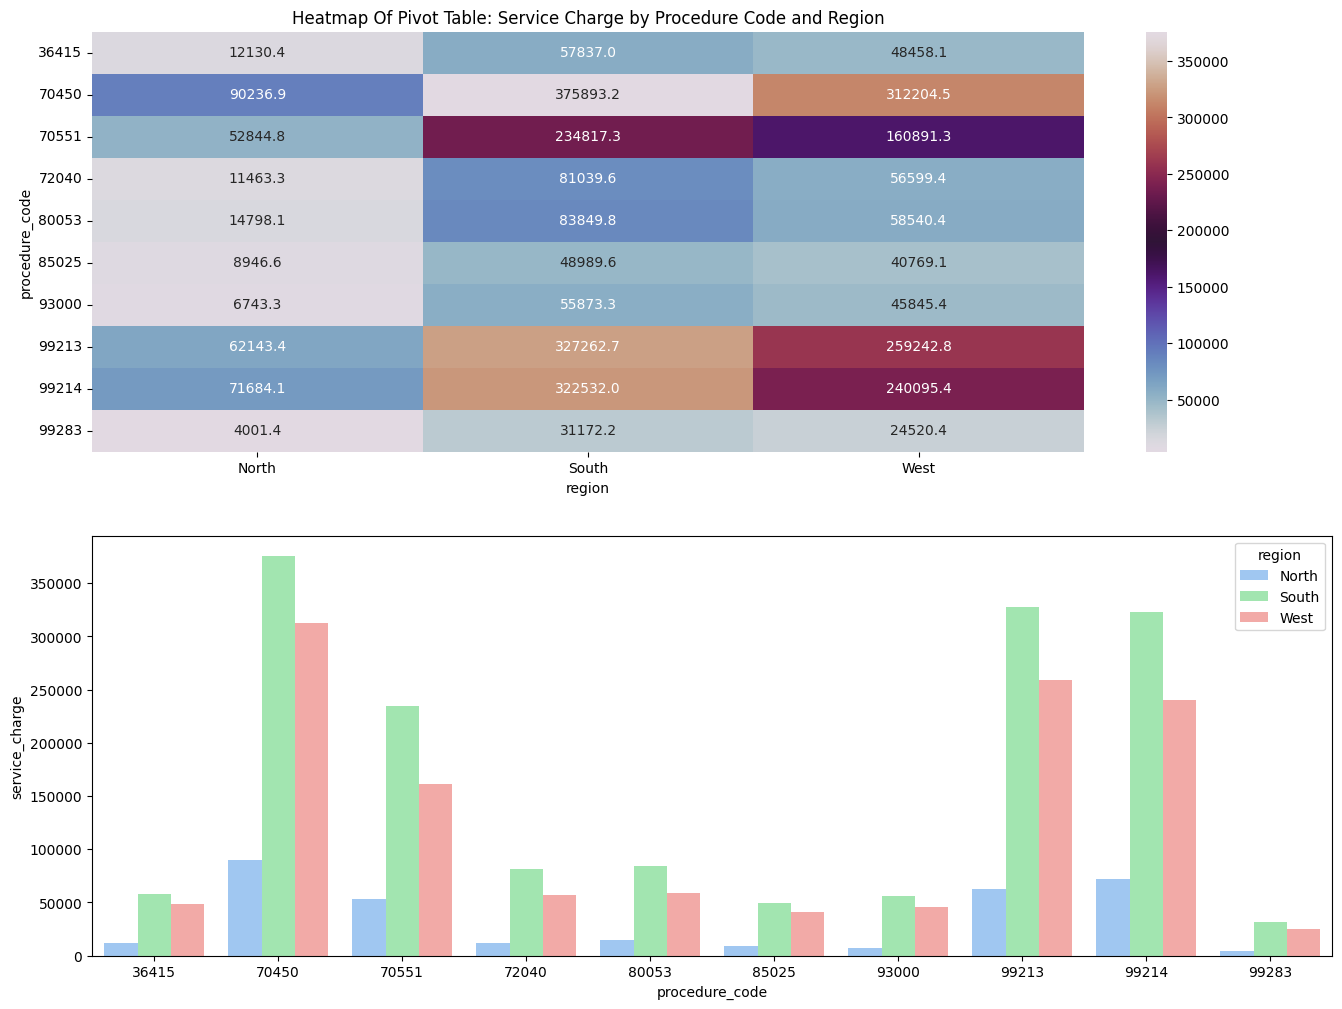

In [65]:
plt.style.use('seaborn-v0_8-pastel')
fig, axes = plt.subplots(2, 1, figsize = (16, 12))

# Create heatmap from pivot table 
sns.heatmap(
    data = pivot,
    annot = True,
    cmap = "twilight",
    fmt = '.1f',
    ax = axes[0],
)
axes[0].set_title('Heatmap Of Pivot Table: Service Charge [Sum] by Procedure Code and Region')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Procedure Code')

# Create bar chart from pivot table
sns.barplot(
    data = pivot.reset_index().melt(
        id_vars = 'procedure_code',
        var_name = 'region',
        value_name = 'service_charge'
    ),
    x = 'procedure_code',
    y = 'service_charge',
    hue = 'region',
    ax = axes[1]
)
axes[1].set_title('Barchart of Pivot Table: Service Charge [Sum] by Procedure Code and Region')
axes[1].set_xlabel('Procedure Code')
axes[1].set_ylabel('Service Charge [Sum]')

# Save the plot as 'output/q3_pivot_visualization.png'
plt.savefig('output/q3_pivot_visualization.png')

## Submission Checklist

Before submitting, verify you've created:

- [ ] `output/q1_groupby_analysis.csv` - Basic groupby analysis
- [ ] `output/q1_aggregation_report.txt` - Aggregation report
- [ ] `output/q2_filter_analysis.csv` - Filter operations analysis
- [ ] `output/q2_hierarchical_analysis.csv` - Hierarchical analysis
- [ ] `output/q2_performance_report.txt` - Performance report
- [ ] `output/q3_pivot_analysis.csv` - Pivot table analysis
- [ ] `output/q3_crosstab_analysis.csv` - Cross-tabulation analysis
- [ ] `output/q3_pivot_visualization.png` - Pivot visualization

## Key Learning Objectives

- Master the split-apply-combine paradigm
- Apply aggregation functions and transformations
- Create pivot tables for multi-dimensional analysis
- Apply advanced groupby techniques